# The SOAP descriptor, Gaussian Approximation Potentials (GAP) and machine-learning of force fields 

Adam Fekete, Matrina Stella, Henry Lambert, Alessandro De Vita, Gabor Csanyi (gc121@cam.ac.uk)

## Introduction

In this tutorial we will be using a Gaussaion Approximation Potentials to analyse results of TB DFT calculations of Si surface. Along the way we will learn about different descriptors (2b, 3b, soap) to describe local atomic environment in order to predict energies and forces of Si surface. 

### Tutorial overview:

1. [The data (Nomad, Imeall)](#The-data)
2. [Analysis of the data - Definition of Local Atomic Enviroment](#2.-Analysis-of-the-data---Definition-of-Local-Atomic-Enviroment)
    1. [coordination number](#Coordination-Numbers)
    2. [centrosymmetry parameter analysis](#Centrosymmetry-parameter-analysis)
    3. [polyhedral template matching](#Polyhedral-Template-Matching)
3. [Machine Learning methods: Clustering](#3.-Machine-Learning-methods:--Clustering)

- MD
- descriptors:
  - 2b
  - soap
  
- gap

Usefull links and another tutorials:
- https://wiki.fysik.dtu.dk/ase/tutorials/md/md.html
- https://libatoms.github.io/QUIP/Tutorials/quippy-descriptor-tutorial.html
- https://libatoms.github.io/QUIP/adaptive-qmmm-solutions.html#make-crack



In [1]:
from __future__ import print_function

import numpy as np

from quippy import *

from ase import units
from ase import Atoms as aseAtoms
from ase.build import add_vacuum
from ase.lattice.cubic import Diamond
from ase.io.trajectory import Trajectory
from ase.io import write

from ase.constraints import FixAtoms

from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin

from IPython.display import display
from scripts.Visualise import ViewStructure, MyASEStructure
import nglview

import matplotlib.pylab as plt

# from quippy import verbosity_push, PRINT_VERBOSE
# verbosity_push(PRINT_VERBOSE)


## Parameters

We can define soma parameters here for the MD:

In [2]:
T = 1000.0 # Kelvin
timestep = 1.0 * units.fs

## System

Generating configuration for  Si surface

In [3]:
def build_slab(size=(1,2,2), vacuum=10.):
    # Build Si lattice.
    # lattice = Diamond('Si', directions=([1, 0, 0], [0, 1, 0], [0, 0, 1]), latticeconstant=5.44, size=size)
    lattice = Diamond('Si', latticeconstant=5.44, size=size)
    atoms = Atoms(lattice)
    

    # Fixing the bottom layer     
    bottom = atoms.positions[:,2].min()
    fixed_mask = (abs(atoms.positions[:,2] - bottom) < 2.0)
    atoms.set_constraint(FixAtoms(mask=fixed_mask))
    
    # build surface by adding space to z direction
    add_vacuum(atoms, vacuum)
    # atoms.center(vacuum=10.0, axis=2)
    
    return atoms


atoms = build_slab()
print('Number of atoms:', len(atoms))

Number of atoms: 32


Let's visualise the initial configuration:

In [4]:
def visualise(atoms, repetition=(1,1,1)):
# visualisation
    view = nglview.NGLWidget(gui=False)
    view.stage.set_parameters(clip_dist=0)
    view.add_structure(MyASEStructure(atoms))
    view.add_unitcell()
    view.add_structure(MyASEStructure(supercell(atoms, *repetition)))
    return view

view = visualise(atoms)
display(view)

NGLWidget()

## Calculator TD DFT

In [5]:
# attach tight binding calculator
qm_pot = Potential('TB DFTB', param_filename='/opt/quip/doc/params.xml')
atoms.set_calculator(qm_pot)

# Thermalize atoms
MaxwellBoltzmannDistribution(atoms, 2.0 * T * units.kB)
# dynamics = VelocityVerlet(atoms, timestep)
dynamics = Langevin(atoms, timestep, T * units.kB, 0.002)
    
#attach observer to dynamics to track quantity of interest (temperature)
def print_status():    
    print('Step = {}, time = {} [fs], T = {} [K]'.format(
        dynamics.nsteps,
        dynamics.nsteps * dynamics.dt / units.fs,
        atoms.get_kinetic_energy() / (1.5 * units.kB * len(atoms))
    ))

def print_energy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
dynamics.attach(print_status, interval=1)
dynamics.attach(print_energy, interval=1)

## run dynamics

In [6]:
dynamics.run(steps=100)

# for _ in range(150):
#     dynamics.run(steps=1)

Step = 1, time = 1.0 [fs], T = 1391.59057233 [K]
Energy per atom: Epot = -34.783eV  Ekin = 0.180eV (T=1392K)  Etot = -34.603eV
Step = 2, time = 2.0 [fs], T = 1379.13105714 [K]
Energy per atom: Epot = -34.780eV  Ekin = 0.178eV (T=1379K)  Etot = -34.602eV
Step = 3, time = 3.0 [fs], T = 1354.37254173 [K]
Energy per atom: Epot = -34.777eV  Ekin = 0.175eV (T=1354K)  Etot = -34.601eV
Step = 4, time = 4.0 [fs], T = 1315.24498029 [K]
Energy per atom: Epot = -34.772eV  Ekin = 0.170eV (T=1315K)  Etot = -34.602eV
Step = 5, time = 5.0 [fs], T = 1265.34278891 [K]
Energy per atom: Epot = -34.766eV  Ekin = 0.164eV (T=1265K)  Etot = -34.602eV
Step = 6, time = 6.0 [fs], T = 1215.32751549 [K]
Energy per atom: Epot = -34.759eV  Ekin = 0.157eV (T=1215K)  Etot = -34.602eV
Step = 7, time = 7.0 [fs], T = 1153.21517137 [K]
Energy per atom: Epot = -34.751eV  Ekin = 0.149eV (T=1153K)  Etot = -34.602eV
Step = 8, time = 8.0 [fs], T = 1096.30523365 [K]
Energy per atom: Epot = -34.742eV  Ekin = 0.142eV (T=1096K)  E

Step = 67, time = 67.0 [fs], T = 720.814716786 [K]
Energy per atom: Epot = -34.694eV  Ekin = 0.093eV (T=721K)  Etot = -34.601eV
Step = 68, time = 68.0 [fs], T = 730.94531531 [K]
Energy per atom: Epot = -34.695eV  Ekin = 0.094eV (T=731K)  Etot = -34.601eV
Step = 69, time = 69.0 [fs], T = 749.993842824 [K]
Energy per atom: Epot = -34.697eV  Ekin = 0.097eV (T=750K)  Etot = -34.600eV
Step = 70, time = 70.0 [fs], T = 762.907496596 [K]
Energy per atom: Epot = -34.699eV  Ekin = 0.099eV (T=763K)  Etot = -34.600eV
Step = 71, time = 71.0 [fs], T = 777.6571539 [K]
Energy per atom: Epot = -34.701eV  Ekin = 0.101eV (T=778K)  Etot = -34.600eV
Step = 72, time = 72.0 [fs], T = 791.883170373 [K]
Energy per atom: Epot = -34.703eV  Ekin = 0.102eV (T=792K)  Etot = -34.600eV
Step = 73, time = 73.0 [fs], T = 804.003511317 [K]
Energy per atom: Epot = -34.704eV  Ekin = 0.104eV (T=804K)  Etot = -34.600eV
Step = 74, time = 74.0 [fs], T = 817.09068635 [K]
Energy per atom: Epot = -34.706eV  Ekin = 0.106eV (T=817K

In [7]:
view = visualise(atoms)
display(view)

NGLWidget()

## Descriptors

https://libatoms.github.io/QUIP/Tutorials/quippy-descriptor-tutorial.html

## Pairwise

Here we use a simple pair distance between Silicon atoms, with a cutoff of 3.0 Angstrom. There are several descriptors that can do this, one is distance_2b, which takes a cutoff argument, and two Z values to specify the atom types. Alternatively, the distance_Nb descriptor could also do this, with order=2, and it takes a string of Zs to specify the atom types. This is more general, order=3 is a triangle-like three-body descriptor of the three sides of a triangle of 3 atoms.

In [8]:
desc = Descriptor("distance_Nb order=2 cutoff=4.0")

This descriptor is very simple: it is scalar (dimension 1), and hence only has a single permutation.

In [9]:
desc.n_perm # number of permutations

2

In [10]:
desc.permutations() # array of permutation arrays


array([[1],
       [1]], dtype=int32)

Many descriptors rely on the neighbour connectivity, so we need to call calc_connect, after setting the Atoms cutoff with a skin of 1 A:

In [11]:
atoms.set_cutoff(desc.cutoff())
atoms.calc_connect()

We can now calculate how many instances of this descriptor are found in an Atoms (or ASEAtoms) object:

In [12]:
desc.count(atoms)

197

This also works transparently for iterables (such as lists), returning a list of the counts.

We can also calculate the actual descriptor values – in this case, the list of pairwise distances:

In [13]:
d = desc.calc(atoms)
# for k,v in d.items():
#     print(k)
#     print(type(v))
# d

Notice that the first array is called cutoff, and it supplies the value of a cutoff function, implicit in all descriptors, which takes the descriptor value to zero as the atoms approach the cutoff, i.e. in this case as the distance between the two atoms approaches the cutoff. It is more complicated for three-body and higher-body descriptors, but the end result is always a descriptor which changes smoothly with atomic positions.

Here is a histogram of the resulting descriptor array, i.e. of the interatomic distances

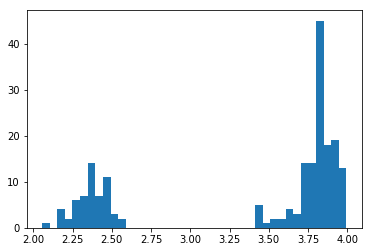

In [14]:
plt.hist(d.descriptor, bins=40)
plt.show()

In [15]:
atoms.get_potential_energy()

-1111.7590299859887

Calculate size of descriptor data:


In [16]:
n_desc, n_cross = desc.descriptor_sizes(atoms)
print("n_desc=%d n_cross=%d" % (n_desc, n_cross))

n_desc=197 n_cross=394


In [18]:
# conf_desciptors = []
# conf_energies = []
# for conf in db:
#     conf.set_cutoff(desc.cutoff() + 1.0)
#     conf.calc_connect()
    
#     conf_desciptors.append(desc.calc(conf))
    
#     conf.set_calculator(qm_pot)

#     conf_energies.append(conf.get_potential_energy())

In [19]:
# plt.plot(conf_energies)

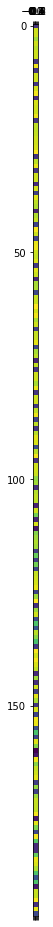

In [20]:
plt.matshow(d['descriptor'])

In [21]:
n_desc, n_cross = desc.descriptor_sizes(atoms)
print("n_desc=%d n_cross=%d" % (n_desc,n_cross))

n_desc=197 n_cross=394


## SOAP Kernel and descriptor

Next, we need to define a kernel. There are many ways to define what the atomic charges would be a function of, but somehow we need to describe the environment of the atom, and then construct a similarity function that can serve as the kernel function. 

In this tutorial, we are going to make the atomic charge a function of the near-environment of an atom (within a cutoff), and we will describe that environment using the SOAP descriptor and compare them using the SOAP kernel. Note right away that the quantum mechanically computed atomic charge is not fully determined by the near-environment of atoms (far-away atoms can also influence the charge, even if just to a small extent), so this is an early indication that we will be making use of the "noise" interpretation of the $\lambda$ regularization parameter: we don't expect (and don't want) our fitted function to precisely go through each datapoint.

The SOAP descriptor of an atomic environment is based on a spherical harmonic expansion of the neighbour density, and truncating this expansion at some maximum numer of radial (n_max) and angular (l_max) indices gives rise to some parameters. We also need to give the cutoff within which we consider the neighbour environment.

Writing the descriptor vector as $p_{ss'nn'l}$, where $s$ and $s'$ are indices that run over the different atomic species in the atom's environment, $n$ and $n'$ are radial and $l$ is an angular index, the kernel between two atomic environments is

$$
K(p,p') = \delta^2 \left| \sum_{ss'nn'l} p_{ss'nn'l} p'_{ss'nn'l}\right|^\zeta \equiv \delta^2 \left| {\bf p} \cdot {\bf p'}\right|^\zeta
$$

The factor of $\delta^2$ allows the setting of the scale of fitted function, relative to the error specification $\lambda$. 

In [22]:
desc = Descriptor("soap cutoff=4 l_max=3 n_max=4 normalize=T atom_sigma=0.5 n_Z=1 Z={14} ")

In [23]:

atoms.set_cutoff(desc.cutoff())
atoms.calc_connect()

There are now only 8 descriptors, because SOAP produces one for each atom in the structure

In [24]:
desc.descriptor_sizes(atoms)


(32, 426)

But each descriptor now is a long vector, because it encodes the entire environment of the atom up to the cutoff. The length of the vector depends on l_max and n_max and also on the number of atom types.

In [25]:
d = desc.calc(atoms)
# d

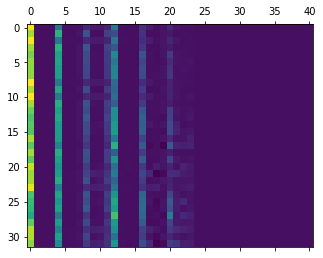

In [26]:
plt.matshow(d.descriptor)

In [27]:
db = []
def collect_data():
    db.append(atoms.copy())

dynamics.attach(collect_data, interval=10)
dynamics.run(steps=500)

Step = 101, time = 101.0 [fs], T = 1152.52093021 [K]
Energy per atom: Epot = -34.745eV  Ekin = 0.149eV (T=1153K)  Etot = -34.596eV
Step = 102, time = 102.0 [fs], T = 1164.82968223 [K]
Energy per atom: Epot = -34.747eV  Ekin = 0.151eV (T=1165K)  Etot = -34.597eV
Step = 103, time = 103.0 [fs], T = 1169.70182107 [K]
Energy per atom: Epot = -34.749eV  Ekin = 0.151eV (T=1170K)  Etot = -34.598eV
Step = 104, time = 104.0 [fs], T = 1181.71871457 [K]
Energy per atom: Epot = -34.750eV  Ekin = 0.153eV (T=1182K)  Etot = -34.598eV
Step = 105, time = 105.0 [fs], T = 1176.54180657 [K]
Energy per atom: Epot = -34.751eV  Ekin = 0.152eV (T=1177K)  Etot = -34.599eV
Step = 106, time = 106.0 [fs], T = 1169.776616 [K]
Energy per atom: Epot = -34.752eV  Ekin = 0.151eV (T=1170K)  Etot = -34.601eV
Step = 107, time = 107.0 [fs], T = 1165.31063335 [K]
Energy per atom: Epot = -34.752eV  Ekin = 0.151eV (T=1165K)  Etot = -34.601eV
Step = 108, time = 108.0 [fs], T = 1162.9363076 [K]
Energy per atom: Epot = -34.751eV

Energy per atom: Epot = -34.717eV  Ekin = 0.116eV (T=897K)  Etot = -34.601eV
Step = 165, time = 165.0 [fs], T = 884.925100477 [K]
Energy per atom: Epot = -34.716eV  Ekin = 0.114eV (T=885K)  Etot = -34.601eV
Step = 166, time = 166.0 [fs], T = 874.693532032 [K]
Energy per atom: Epot = -34.715eV  Ekin = 0.113eV (T=875K)  Etot = -34.602eV
Step = 167, time = 167.0 [fs], T = 877.432853375 [K]
Energy per atom: Epot = -34.714eV  Ekin = 0.113eV (T=877K)  Etot = -34.600eV
Step = 168, time = 168.0 [fs], T = 877.16810294 [K]
Energy per atom: Epot = -34.713eV  Ekin = 0.113eV (T=877K)  Etot = -34.600eV
Step = 169, time = 169.0 [fs], T = 869.99957212 [K]
Energy per atom: Epot = -34.712eV  Ekin = 0.112eV (T=870K)  Etot = -34.600eV
Step = 170, time = 170.0 [fs], T = 873.263430492 [K]
Energy per atom: Epot = -34.712eV  Ekin = 0.113eV (T=873K)  Etot = -34.599eV
Step = 171, time = 171.0 [fs], T = 866.660530022 [K]
Energy per atom: Epot = -34.711eV  Ekin = 0.112eV (T=867K)  Etot = -34.599eV
Step = 172, tim

Step = 228, time = 228.0 [fs], T = 992.31338956 [K]
Energy per atom: Epot = -34.736eV  Ekin = 0.128eV (T=992K)  Etot = -34.607eV
Step = 229, time = 229.0 [fs], T = 997.354117398 [K]
Energy per atom: Epot = -34.736eV  Ekin = 0.129eV (T=997K)  Etot = -34.607eV
Step = 230, time = 230.0 [fs], T = 998.511907649 [K]
Energy per atom: Epot = -34.736eV  Ekin = 0.129eV (T=999K)  Etot = -34.607eV
Step = 231, time = 231.0 [fs], T = 1000.49201776 [K]
Energy per atom: Epot = -34.736eV  Ekin = 0.129eV (T=1000K)  Etot = -34.607eV
Step = 232, time = 232.0 [fs], T = 998.737518665 [K]
Energy per atom: Epot = -34.736eV  Ekin = 0.129eV (T=999K)  Etot = -34.607eV
Step = 233, time = 233.0 [fs], T = 996.240993114 [K]
Energy per atom: Epot = -34.736eV  Ekin = 0.129eV (T=996K)  Etot = -34.607eV
Step = 234, time = 234.0 [fs], T = 997.269408771 [K]
Energy per atom: Epot = -34.735eV  Ekin = 0.129eV (T=997K)  Etot = -34.606eV
Step = 235, time = 235.0 [fs], T = 995.02129563 [K]
Energy per atom: Epot = -34.735eV  Eki

Energy per atom: Epot = -34.739eV  Ekin = 0.133eV (T=1031K)  Etot = -34.606eV
Step = 292, time = 292.0 [fs], T = 1015.809306 [K]
Energy per atom: Epot = -34.738eV  Ekin = 0.131eV (T=1016K)  Etot = -34.606eV
Step = 293, time = 293.0 [fs], T = 1009.2945874 [K]
Energy per atom: Epot = -34.736eV  Ekin = 0.130eV (T=1009K)  Etot = -34.605eV
Step = 294, time = 294.0 [fs], T = 993.615887413 [K]
Energy per atom: Epot = -34.734eV  Ekin = 0.128eV (T=994K)  Etot = -34.605eV
Step = 295, time = 295.0 [fs], T = 971.124714658 [K]
Energy per atom: Epot = -34.731eV  Ekin = 0.126eV (T=971K)  Etot = -34.606eV
Step = 296, time = 296.0 [fs], T = 947.900505427 [K]
Energy per atom: Epot = -34.729eV  Ekin = 0.123eV (T=948K)  Etot = -34.606eV
Step = 297, time = 297.0 [fs], T = 924.273266109 [K]
Energy per atom: Epot = -34.726eV  Ekin = 0.119eV (T=924K)  Etot = -34.607eV
Step = 298, time = 298.0 [fs], T = 907.708525232 [K]
Energy per atom: Epot = -34.724eV  Ekin = 0.117eV (T=908K)  Etot = -34.606eV
Step = 299, t

Step = 356, time = 356.0 [fs], T = 787.060119284 [K]
Energy per atom: Epot = -34.704eV  Ekin = 0.102eV (T=787K)  Etot = -34.602eV
Step = 357, time = 357.0 [fs], T = 790.019911856 [K]
Energy per atom: Epot = -34.704eV  Ekin = 0.102eV (T=790K)  Etot = -34.602eV
Step = 358, time = 358.0 [fs], T = 791.464381965 [K]
Energy per atom: Epot = -34.705eV  Ekin = 0.102eV (T=791K)  Etot = -34.603eV
Step = 359, time = 359.0 [fs], T = 792.434454122 [K]
Energy per atom: Epot = -34.706eV  Ekin = 0.102eV (T=792K)  Etot = -34.604eV
Step = 360, time = 360.0 [fs], T = 806.145492489 [K]
Energy per atom: Epot = -34.708eV  Ekin = 0.104eV (T=806K)  Etot = -34.604eV
Step = 361, time = 361.0 [fs], T = 821.24587994 [K]
Energy per atom: Epot = -34.710eV  Ekin = 0.106eV (T=821K)  Etot = -34.604eV
Step = 362, time = 362.0 [fs], T = 836.058997025 [K]
Energy per atom: Epot = -34.712eV  Ekin = 0.108eV (T=836K)  Etot = -34.604eV
Step = 363, time = 363.0 [fs], T = 862.394700438 [K]
Energy per atom: Epot = -34.715eV  Eki

Step = 420, time = 420.0 [fs], T = 1126.09961884 [K]
Energy per atom: Epot = -34.754eV  Ekin = 0.146eV (T=1126K)  Etot = -34.608eV
Step = 421, time = 421.0 [fs], T = 1140.17500939 [K]
Energy per atom: Epot = -34.755eV  Ekin = 0.147eV (T=1140K)  Etot = -34.608eV
Step = 422, time = 422.0 [fs], T = 1147.05570974 [K]
Energy per atom: Epot = -34.756eV  Ekin = 0.148eV (T=1147K)  Etot = -34.608eV
Step = 423, time = 423.0 [fs], T = 1155.1556442 [K]
Energy per atom: Epot = -34.756eV  Ekin = 0.149eV (T=1155K)  Etot = -34.607eV
Step = 424, time = 424.0 [fs], T = 1154.87199011 [K]
Energy per atom: Epot = -34.756eV  Ekin = 0.149eV (T=1155K)  Etot = -34.607eV
Step = 425, time = 425.0 [fs], T = 1144.3128304 [K]
Energy per atom: Epot = -34.755eV  Ekin = 0.148eV (T=1144K)  Etot = -34.607eV
Step = 426, time = 426.0 [fs], T = 1129.40563179 [K]
Energy per atom: Epot = -34.753eV  Ekin = 0.146eV (T=1129K)  Etot = -34.607eV
Step = 427, time = 427.0 [fs], T = 1111.0445371 [K]
Energy per atom: Epot = -34.751eV

Step = 484, time = 484.0 [fs], T = 992.114166264 [K]
Energy per atom: Epot = -34.740eV  Ekin = 0.128eV (T=992K)  Etot = -34.611eV
Step = 485, time = 485.0 [fs], T = 1010.00227613 [K]
Energy per atom: Epot = -34.741eV  Ekin = 0.131eV (T=1010K)  Etot = -34.611eV
Step = 486, time = 486.0 [fs], T = 1026.95419327 [K]
Energy per atom: Epot = -34.743eV  Ekin = 0.133eV (T=1027K)  Etot = -34.610eV
Step = 487, time = 487.0 [fs], T = 1037.11391119 [K]
Energy per atom: Epot = -34.745eV  Ekin = 0.134eV (T=1037K)  Etot = -34.610eV
Step = 488, time = 488.0 [fs], T = 1043.06811179 [K]
Energy per atom: Epot = -34.746eV  Ekin = 0.135eV (T=1043K)  Etot = -34.611eV
Step = 489, time = 489.0 [fs], T = 1048.348172 [K]
Energy per atom: Epot = -34.746eV  Ekin = 0.136eV (T=1048K)  Etot = -34.611eV
Step = 490, time = 490.0 [fs], T = 1052.38565441 [K]
Energy per atom: Epot = -34.747eV  Ekin = 0.136eV (T=1052K)  Etot = -34.611eV
Step = 491, time = 491.0 [fs], T = 1052.20696057 [K]
Energy per atom: Epot = -34.747eV

Energy per atom: Epot = -34.712eV  Ekin = 0.099eV (T=769K)  Etot = -34.612eV
Step = 548, time = 548.0 [fs], T = 761.916644819 [K]
Energy per atom: Epot = -34.711eV  Ekin = 0.098eV (T=762K)  Etot = -34.612eV
Step = 549, time = 549.0 [fs], T = 755.339497834 [K]
Energy per atom: Epot = -34.710eV  Ekin = 0.098eV (T=755K)  Etot = -34.612eV
Step = 550, time = 550.0 [fs], T = 749.702397874 [K]
Energy per atom: Epot = -34.709eV  Ekin = 0.097eV (T=750K)  Etot = -34.612eV
Step = 551, time = 551.0 [fs], T = 746.318668046 [K]
Energy per atom: Epot = -34.709eV  Ekin = 0.096eV (T=746K)  Etot = -34.612eV
Step = 552, time = 552.0 [fs], T = 740.20377054 [K]
Energy per atom: Epot = -34.709eV  Ekin = 0.096eV (T=740K)  Etot = -34.613eV
Step = 553, time = 553.0 [fs], T = 745.98952727 [K]
Energy per atom: Epot = -34.709eV  Ekin = 0.096eV (T=746K)  Etot = -34.613eV
Step = 554, time = 554.0 [fs], T = 751.478579879 [K]
Energy per atom: Epot = -34.710eV  Ekin = 0.097eV (T=751K)  Etot = -34.612eV
Step = 555, tim

In [28]:
len(db)

50

In [29]:
write("tmp.xyz", db)


In [30]:
isolated_atom = aseAtoms("Si", positions=[[0,0,0]])
isolated_atom.set_calculator(qm_pot)
E0 = isolated_atom.get_potential_energy()
E0

-29.716948405885105

In [31]:
!teach_sparse --help

libAtoms::Hello World: 27/09/2018   00:43:18
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,531330f
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Sep 26 2018 at 01:27:23
libAtoms::Hello World: OpenMP parallelisation with 2 threads
libAtoms::Hello World: Random Seed = 2598426
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default

at_file type=STRING scalar current_value=//MANDATORY//
XYZ file with teaching configurations

gap type=STRING scalar current_value=//MANDATORY//
Initialisation string for GAPs

e0 type=STRING scalar current_value=0.0
Atomic energy value to be subtracted from energies before fitting (and added
back on after prediction). Specifiy a single number (used for all species) or
by species: {Ti:-150.0:O:-320}. energy = core + GAP +
e0

e0_offset type=REAL scalar current_value=0.0
Offset of baseline. If zero, the offset is the average atomic energy of t

In [32]:
!teach_sparse at_file=dummy default_sigma={0 0 0 0} gap={distance_Nb delta=0.0 covariance_type=ARD_SE --help}

libAtoms::Hello World: 27/09/2018   00:43:18
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,531330f
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Sep 26 2018 at 01:27:23
libAtoms::Hello World: OpenMP parallelisation with 2 threads
libAtoms::Hello World: Random Seed = 2598834
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = dummy
gap = "distance_Nb delta=0.0 covariance_type=ARD_SE --help"
e0 = 0.0
e0_offset = 0.0
do_e0_avg = T
default_sigma = "0 0 0 0"
sparse_jitter = 1.0e-10
hessian_delta = 1.0e-2
core_param_file = quip_params.xml
core_ip_args =
energy_parameter_name = energy
force_parameter_name = force
virial_parameter_name = virial
hessian_parameter_name = hessian
config_type_parameter_name = config_type
sigma_parameter_name = sigma
config_type_sigma =
sigma_per_atom

In [33]:
!teach_sparse at_file=tmp.xyz gap={distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0} e0=-29.716948405885105 default_sigma={0.01 0.5 0.0 0.0} do_copy_at_file=F sparse_separate_file=F gp_file=gap_2b.xml

libAtoms::Hello World: 27/09/2018   00:43:19
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,531330f
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Sep 26 2018 at 01:27:23
libAtoms::Hello World: OpenMP parallelisation with 2 threads
libAtoms::Hello World: Random Seed = 2599268
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = tmp.xyz
gap = "distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0"
e0 = -29.716948405885105
e0_offset = 0.0
do_e0_avg = T
default_sigma = "0.01 0.5 0.0 0.0"
sparse_jitter = 1.0e-10
hessian_delta = 1.0e-2
core_param_file = quip_params.xml
core_ip_args =
energy_parameter_name = energy
force_parameter_name = force
virial_parameter_name = virial
hessian_parameter_name = hessian
config_type_parameter_name = config

In [34]:
gap2b = Potential(param_filename="gap_2b.xml")

In [35]:
db[0].energy

-1111.9321079333781

In [36]:
len(db)

50

In [37]:
qm_energies = [dba.energy for dba in db]
gap2b_energies = []
for dba in db:
    a = dba.copy()
    a.set_calculator(gap2b)
    gap2b_energies.append(a.get_potential_energy())
    

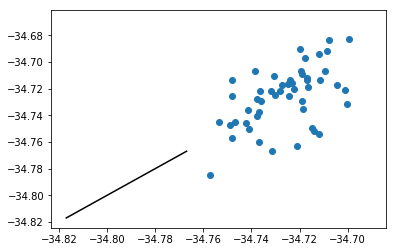

In [38]:
Natoms = len(db[0])
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap2b_energies)/Natoms)
plt.plot([E0-5.1, E0-5.1+0.05], [E0-5.1, E0-5.1+0.05], "k-")
plt.show()

In [39]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap2b_energies)/Natoms)**2)/len(gap2b_energies))

0.018927733703977996

In [40]:
dimers = [aseAtoms("2Si", positions=[[0,0,0], [x, 0,0]]) for x in np.linspace(1.6,6,100)] 

In [41]:

dimer_curve = []
for dim in dimers:
    dim.set_calculator(gap2b)
    dimer_curve.append(dim.get_potential_energy())

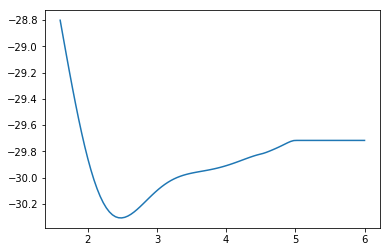

In [42]:
plt.plot([dim.positions[1,0] for dim in dimers], np.array(dimer_curve)/2.0)
plt.show()

In [43]:
!teach_sparse at_file=tmp.xyz gap={distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0:distance_Nb order=3 cutoff=4.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=50 delta=0.004} e0=-29.716948405885105 default_sigma={0.005 0.5 0.0 0.0} do_copy_at_file=F sparse_separate_file=F gp_file=gap_3b.xml

libAtoms::Hello World: 27/09/2018   00:43:22
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,531330f
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Sep 26 2018 at 01:27:23
libAtoms::Hello World: OpenMP parallelisation with 2 threads
libAtoms::Hello World: Random Seed = 2602047
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = tmp.xyz
gap = "distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0:distance_Nb order=3 cutoff=4.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=50 delta=0.004"
e0 = -29.716948405885105
e0_offset = 0.0
do_e0_avg = T
default_sigma = "0.005 0.5 0.0 0.0"
sparse_jitter = 1.0e-10
hessian_delta = 1.0e-2
core_param_file = quip_params.xml
core_ip_args =
energy_parameter_name = energy
force_parameter_name = force
vi

In [44]:
gap3b = Potential(param_filename="gap_3b.xml")
gap3b_energies = []
for dba in db:
    a = dba.copy()
    a.set_calculator(gap3b)
    gap3b_energies.append(a.get_potential_energy())
    

In [45]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap3b_energies)/Natoms)**2)/len(gap3b_energies))

0.009284903136870597

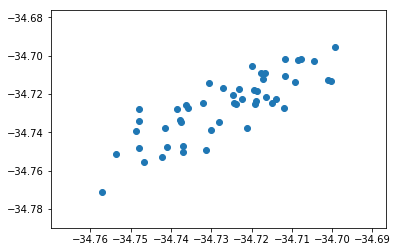

In [46]:
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap3b_energies)/Natoms)
plt.show()

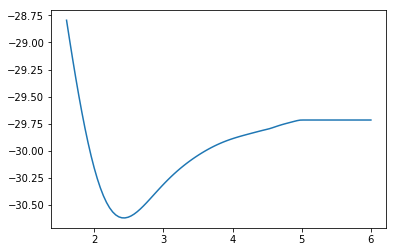

In [47]:
dimer_curve = []
for dim in dimers:
    dim.set_calculator(gap3b)
    dimer_curve.append(dim.get_potential_energy())
    
plt.plot([dim.positions[1,0] for dim in dimers], np.array(dimer_curve)/2.0)
plt.show()

In [48]:
!teach_sparse at_file=tmp.xyz gap={distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0:distance_Nb order=3 cutoff=4.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=50 delta=0.004:soap cutoff=4.0 covariance_type=dot_product zeta=2 delta=0.016 atom_sigma=0.7 l_max=6 n_max=6 n_sparse=200 sparse_method=cur_points} e0=-29.716948405885105 default_sigma={0.001 0.5 0.0 0.0} do_copy_at_file=F sparse_separate_file=F gp_file=gap_2b3bsoap.xml 2>&1 | grep -v FoX

libAtoms::Hello World: 27/09/2018   00:43:30
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,531330f
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Sep 26 2018 at 01:27:23
libAtoms::Hello World: OpenMP parallelisation with 2 threads
libAtoms::Hello World: Random Seed = 2610900
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = tmp.xyz
gap = "distance_Nb order=2 cutoff=5.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=15 delta=1.0:distance_Nb order=3 cutoff=4.0 covariance_type=ARD_SE theta_uniform=1.0 n_sparse=50 delta=0.004:soap cutoff=4.0 covariance_type=dot_product zeta=2 delta=0.016 atom_sigma=0.7 l_max=6 n_max=6 n_sparse=200 sparse_method=cur_points"
e0 = -29.716948405885105
e0_offset = 0.0
do_e0_avg = T
default_sigma = "0.001 0.5 0.0 0.0"
sparse_jitter = 1.0e-10
he

In [49]:
gap_soap = Potential(param_filename="gap_2b3bsoap.xml")
gap_energies = []
for dba in db:
    a = dba.copy()
    a.set_calculator(gap_soap)
    gap_energies.append(a.get_potential_energy())
    

In [50]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap_energies)/Natoms)**2)/len(gap_energies))

0.003092876937693682

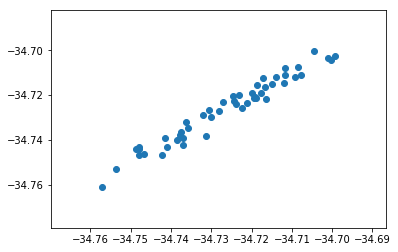

In [51]:
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap_energies)/Natoms)
plt.show()

In [52]:



#attach tight binding calculator
atoms.set_calculator(gap_soap)


# Thermalize atoms
# MaxwellBoltzmannDistribution(atoms, 2.0* T * units.kB)

# dynamics = VelocityVerlet(atoms, timestep)
dynamics = Langevin(atoms, timestep, T * units.kB, 0.002)

    
    
dynamics.attach(print_status, interval=10)
dynamics.attach(print_energy, interval=10)





In [53]:
dynamics.run(steps=100)

Step = 10, time = 10.0 [fs], T = 1203.38417971 [K]
Energy per atom: Epot = -34.772eV  Ekin = 0.156eV (T=1203K)  Etot = -34.616eV
Step = 20, time = 20.0 [fs], T = 1205.83380259 [K]
Energy per atom: Epot = -34.772eV  Ekin = 0.156eV (T=1206K)  Etot = -34.616eV
Step = 30, time = 30.0 [fs], T = 1215.34044904 [K]
Energy per atom: Epot = -34.772eV  Ekin = 0.157eV (T=1215K)  Etot = -34.615eV
Step = 40, time = 40.0 [fs], T = 1173.22105987 [K]
Energy per atom: Epot = -34.769eV  Ekin = 0.152eV (T=1173K)  Etot = -34.617eV
Step = 50, time = 50.0 [fs], T = 999.786402116 [K]
Energy per atom: Epot = -34.751eV  Ekin = 0.129eV (T=1000K)  Etot = -34.622eV
Step = 60, time = 60.0 [fs], T = 894.323322788 [K]
Energy per atom: Epot = -34.741eV  Ekin = 0.116eV (T=894K)  Etot = -34.625eV
Step = 70, time = 70.0 [fs], T = 1074.03344815 [K]
Energy per atom: Epot = -34.766eV  Ekin = 0.139eV (T=1074K)  Etot = -34.627eV
Step = 80, time = 80.0 [fs], T = 1109.46870104 [K]
Energy per atom: Epot = -34.772eV  Ekin = 0.143

In [54]:

from ase.optimize.precon import PreconLBFGS, Exp

In [55]:
optatoms = db[0].copy()
optatoms.set_calculator(gap_soap)
opt = PreconLBFGS(optatoms, precon=Exp(3.0))

In [56]:
opt.run(fmax=0.01)

PreconLBFGS:   0  00:43:56    -1111.813930       3.3565
estimate_mu(): mu=1.7754700308625808, mu_c=1.0
PreconLBFGS:   1  00:43:57    -1112.505861       3.1058
PreconLBFGS:   2  00:43:57    -1113.097105       2.8361
PreconLBFGS:   3  00:43:57    -1113.575481       2.6355
PreconLBFGS:   4  00:43:57    -1114.017949       2.4066
PreconLBFGS:   5  00:43:58    -1114.385765       2.2663
PreconLBFGS:   6  00:43:58    -1114.766116       2.0137
PreconLBFGS:   7  00:43:58    -1115.061477       1.8583
PreconLBFGS:   8  00:43:58    -1115.336373       1.6343
PreconLBFGS:   9  00:43:58    -1115.548243       1.4752
PreconLBFGS:  10  00:43:59    -1115.731227       1.3317
PreconLBFGS:  11  00:43:59    -1115.874189       1.1962
PreconLBFGS:  12  00:43:59    -1115.989827       1.1011
PreconLBFGS:  13  00:43:59    -1116.095424       0.9663
PreconLBFGS:  14  00:44:00    -1116.189389       0.8737
PreconLBFGS:  15  00:44:00    -1116.266907       0.7400
PreconLBFGS:  16  00:44:01    -1116.348583       0.6129
P

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...


PreconLBFGS:  24  00:44:02    -1116.583944       0.4341


/opt/conda/envs/python2/lib/python2.7/site-packages/ase/optimize/precon/lbfgs.py:330: UserWarning: Armijo linesearch failed, resetting Hessian and trying again
  'Armijo linesearch failed, resetting Hessian and '


PreconLBFGS:  25  00:44:03    -1116.632064       0.4994
PreconLBFGS:  26  00:44:03    -1116.663109       0.4866
PreconLBFGS:  27  00:44:03    -1116.695279       0.5368
PreconLBFGS:  28  00:44:04    -1116.727585       0.6036
PreconLBFGS:  29  00:44:04    -1116.759629       0.6456
PreconLBFGS:  30  00:44:04    -1116.790030       0.6710
PreconLBFGS:  31  00:44:04    -1116.818261       0.6883
PreconLBFGS:  32  00:44:05    -1116.846665       0.8107
PreconLBFGS:  33  00:44:05    -1116.858282       0.8296


ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...


PreconLBFGS:  34  00:44:05    -1116.858282       0.8296
PreconLBFGS:  35  00:44:05    -1116.880188       0.8511
PreconLBFGS:  36  00:44:06    -1116.924059       0.9973
PreconLBFGS:  37  00:44:06    -1116.980188       1.0562
PreconLBFGS:  38  00:44:06    -1117.033319       1.0689
PreconLBFGS:  39  00:44:06    -1117.076744       1.0660
PreconLBFGS:  40  00:44:07    -1117.117763       1.0648
PreconLBFGS:  41  00:44:07    -1117.151262       1.0606
PreconLBFGS:  42  00:44:07    -1117.183232       1.0659
PreconLBFGS:  43  00:44:08    -1117.211546       1.1087
PreconLBFGS:  44  00:44:08    -1117.238843       1.2116
PreconLBFGS:  45  00:44:08    -1117.266794       1.3649


ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...


PreconLBFGS:  46  00:44:08    -1117.266794       1.3649
PreconLBFGS:  47  00:44:09    -1117.318572       1.4119
PreconLBFGS:  48  00:44:09    -1117.403177       1.5967
PreconLBFGS:  49  00:44:09    -1117.487221       1.6311
PreconLBFGS:  50  00:44:09    -1117.571878       1.6090
PreconLBFGS:  51  00:44:10    -1117.630355       1.5732
PreconLBFGS:  52  00:44:10    -1117.646350       1.5634


ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...


PreconLBFGS:  53  00:44:10    -1117.646350       1.5634
PreconLBFGS:  54  00:44:10    -1117.676940       1.5299
PreconLBFGS:  55  00:44:11    -1117.735793       1.4624
PreconLBFGS:  56  00:44:11    -1117.805585       1.4147
PreconLBFGS:  57  00:44:11    -1117.872751       1.4911
PreconLBFGS:  58  00:44:11    -1117.933576       1.4566


ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...


PreconLBFGS:  59  00:44:11    -1117.933576       1.4566
PreconLBFGS:  60  00:44:12    -1118.000748       1.4334
PreconLBFGS:  61  00:44:12    -1118.057230       1.3127
PreconLBFGS:  62  00:44:12    -1118.112187       1.1361
PreconLBFGS:  63  00:44:12    -1118.159517       0.9532
PreconLBFGS:  64  00:44:12    -1118.201563       0.7894
PreconLBFGS:  65  00:44:13    -1118.233264       0.5839
PreconLBFGS:  66  00:44:13    -1118.255781       0.3543
PreconLBFGS:  67  00:44:14    -1118.264359       0.2249
PreconLBFGS:  68  00:44:14    -1118.268191       0.0923
PreconLBFGS:  69  00:44:15    -1118.269593       0.0367
PreconLBFGS:  70  00:44:15    -1118.269844       0.0146
PreconLBFGS:  71  00:44:15    -1118.269896       0.0146
PreconLBFGS:  72  00:44:16    -1118.269940       0.0082


True

In [57]:
view = visualise(optatoms, (2,2,1))
display(view)
view.camera= 'orthographic'

NGLWidget()